# sklearn-LDA

代码示例：https://mp.weixin.qq.com/s/hMcJtB3Lss1NBalXRTGZlQ （玉树芝兰） <br>
可视化：https://blog.csdn.net/qq_39496504/article/details/107125284  <br>
sklearn lda参数解读:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
<br>中文版参数解读：https://blog.csdn.net/TiffanyRabbit/article/details/76445909
<br>LDA原理-视频版：https://www.bilibili.com/video/BV1t54y127U8
<br>LDA原理-文字版：https://www.jianshu.com/p/5c510694c07e
<br>score的计算方法：https://github.com/scikit-learn/scikit-learn/blob/844b4be24d20fc42cc13b957374c718956a0db39/sklearn/decomposition/_lda.py#L729
<br>主题困惑度1：https://blog.csdn.net/weixin_43343486/article/details/109255165
<br>主题困惑度2：https://blog.csdn.net/weixin_39676021/article/details/112187210

## 预处理

In [48]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [49]:
zhihu_data = pd.read_csv('/Users/zackyule/work/zhihu_research/新冠疫苗的知乎回答表.csv')
print(zhihu_data.shape)

df = zhihu_data.drop_duplicates()  # 删除重复项
df = df.reset_index(drop=True)  # 删除行索引重排

(19768, 19)


In [50]:
def clean_data(content):
    content = re.sub('<[^<]+?>', '', str(content)
                     ).replace('\n', '').strip()  # 删除html文本
    content = re.sub(r'https://[a-zA-Z0-9.?/&=:]*',
                         '', str(content))  # 删除文本中的网址
    content = re.sub(r'http://[a-zA-Z0-9.?/&=:]*', '', content)

    return content

df['内容'] = df['内容'].apply(clean_data)
print(df.shape, df['内容'][0])
# print(type(df),df.shape)
# print(df.head(2))

(19751, 19) 我自己两针打完是没有任何不良反应，根据接种量和不良反应的人数对比，副作用概率还是很小的。前两个月的那批疫苗的不良反应主要是胃肠道反应。上月开始因为（"强制"划掉）要求中学生接种，过敏反应的比较多。印象比较深刻的是前两日一个小姑凉，接种后高热，接种点用了钙剂和地米没有缓解，接种点120拉到我们发热门诊。家长跑去学校要求第二针不要打，学校老师竟然要求继续接种。跑去接种点要求医生开具不建议接种的证明，那边的医生拒绝。后面是孩子的奶奶在接种点那边大闹，医生才勉强在接种的红单上面写上不建议接种第二针。患者家属说那天下午接种后晕倒的有两三个，护士直接拉个屏风就地抢救，外面排长队继续接种。。。另一个小孩子是接种当天全身皮疹，用了三天钙剂和甲强龙都没消下去。后面去皮肤科住院了。感觉大家都不懂得不良反应上报流程。这个小孩的爸爸在我的建议下拨打了接种点的电话，对方要求把住院检查结果和病历打印过去。这里说一下，一般接种点都会就联系方式，接种后任何不良反应都可以打电话咨询。不要以为接种后观察半小时没事了后面就不管了。当天夜班医生也看了两个接种后不舒服的。抗过敏治疗后回家。刚才神经内科医生在我旁边，问了一下不良反应，他那边住院的主要是前庭神经炎，也有脊髓炎，最重的是一个病毒性脑炎的，住了ICU。这些病是接种后发病的，但有谁说得清是原发性的还是接种后的不良反应。去年刚开始接种的时候本院一个主任打完后出现心悸，头晕头痛，全身乏力，按照他的说法是整个人快死了，当晚跑到科室推了激素缓解。那个主任正值壮年。我们还笑他太夸张了。其他人打了都没事。打了疫苗有没有over的，我有遇到一个。具体不能说。所以看到评论里那些回答，大部分都是基于自己或者身边人的情况。你们获得的信息相对没有我们多。为什么我这么闲，因为外面在下暴雨。没几个人看急诊。希望全市人民身体健康。不要来医院。——————随便写的东西居然有人看。大部分的不良反应都是很轻的。头疼脑热，全身乏力，腹痛，皮疹。一般对症处理一下就没事了。没必要太害怕。我个人意见是，如果最近感觉最近“太弱了”就不要去接种了。比如感冒，熬夜，乏力，过敏体质之类的。接种后等于得了一次小型新冠。你本来身体差，接种后更差，其他疾病就会趁虚而入。等身体好一点再去接种。除非是单位强制接种（我们单位就强制所有人接种）这个就没办法了。另外一个就是现在国家基于某些原

In [56]:
output_path = '/Users/zackyule/work/zhihu_research/lda/result'
file_path = '/Users/zackyule/work/zhihu_research/lda/data'
os.chdir(file_path)
# data=pd.read_excel("data.xlsx", engine='openpyxl')#content type
# print(type(data),data.shape)
# print(data.head(2))
data=df[['内容','类型']]
data = data[:800] # 缩小规模
print(type(data),data.shape)
data.columns = ['content','type']
print(data.head(2))
os.chdir(output_path)
dic_file = "/Users/zackyule/work/zhihu_research/lda/stop_dic/dict.txt"
stop_file = "/Users/zackyule/work/zhihu_research/lda/stop_dic/stopwords.txt"

<class 'pandas.core.frame.DataFrame'> (800, 2)
                                             content    type
0  我自己两针打完是没有任何不良反应，根据接种量和不良反应的人数对比，副作用概率还是很小的。前两...  answer
1  首先，本人已打疫苗。其次，我就是那个之前抵制打疫苗还打了12345投诉的人。我本人身体健康且...  answer


In [57]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [58]:
data["content_cutted"] = data.content.apply(chinese_word_cut)

## LDA分析

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [60]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [61]:
n_features = 1000 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10) # min_df为什么设置这么大？整数代表10个文档
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [62]:
n_topics = 13
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
                                doc_topic_prior=0.1,
                                topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_offset=50, max_iter=50,
                          n_components=8, random_state=0,
                          topic_word_prior=0.01)

### 输出每个主题对应词语 

In [63]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
国家 问题 政府 疫情 事情 权利 新冠 人民 免费 社会 鸡蛋 评论 身体 全民 政策 世界 地方 生命 新闻 原则 发展 情况 防疫 费用 时间
Topic #1:
孩子 国家 重症 公司 小区 单位 小白鼠 父母 体质 办法 结果 政策 上学 原因 医院 检查 后遗症 患者 概率 方式 全部 人数 疾病 基本上 小时候
Topic #2:
口罩 疫情 风险 理由 人群 防疫 原因 传播 影响 同事 传染 地方 信任 地区 个人 人员 病例 群体 工作 人们 环境 玩意 花钱 规定 比例
Topic #3:
感觉 反应 情况 原则 医院 身体 症状 问题 副作用 有点 原因 评论 胳膊 护士 疫情 时间 电话 医生 核酸 生物 结果 朋友 体质 检测 药物
Topic #4:
副作用 问题 概率 个人 国家 风险 工作 情况 无法 身体 几率 能力 效果 防疫 影响 群众 全国 老人 数据 部分 角度 基础 家人 有点 宣传
Topic #5:
免费 排队 社区 一针 工作人员 地方 工作 时间 影响 任务 收费 小时 个人 基金 人员 领导 所有人 原因 情况 医院 免费打 朋友 同事 结果 身体
Topic #6:
病毒 新冠 变异 数据 科学 重症 抗体 产生 研究 原因 国产 时间 效应 活疫苗 反应 辉瑞 个人 疾病 群体 实验 结果 变种 程度 信息 责任
Topic #7:
医生 证明 医院 身体 问题 建议 学校 疾病 情况 高血压 住院 单位 地方 免疫系统 人家 个人 症状 知情 原因 基础 老师 网友 工作 社区 恶心


### 输出每篇文章对应主题 

In [64]:
import numpy as np

In [65]:
topics=lda.transform(tf)

In [66]:
topic = []
for t in topics:
    topic.append(list(t).index(np.max(t)))
data['topic']=topic
data.to_excel("data_topic.xlsx",index=False)

In [67]:
topics[0]#0 1 2 

array([0.0016185 , 0.25104516, 0.00161819, 0.23353726, 0.00161859,
       0.00161832, 0.00161876, 0.50732522])

## 可视化 

In [68]:
import pyLDAvis
import pyLDAvis.sklearn

In [69]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)

## 困惑度 

In [70]:
import matplotlib.pyplot as plt

In [71]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


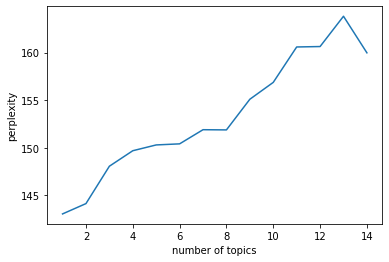

In [72]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

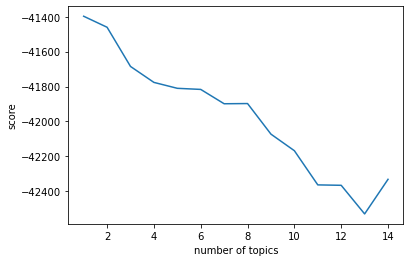

In [73]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,scores[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("score")
plt.show()